In [1]:
import numpy as np
import scipy as scp
from random import seed
from random import random
from random import randrange
from random import uniform
from random import shuffle
from matplotlib import pyplot as plt
import copy
from time import time
from sklearn import preprocessing

In [2]:
class NeuralNetwork:
    class BaseNode:
        def __init__(self, outer, function):
            # outer - obiekt zewnętrzny, w tym wypadku sieć nieuronowa
            self.outer = outer
            # function - funkcja aktywacji
            self.function = function
    class StartNode(BaseNode):
        def __init__(self, outer, function):
            super().__init__(outer, function)
            self.values = []
            self.weightIndexes = []
        def setWeightIndexes(self, weightIndexes): #przekazuje pozycje potrzebnych genów w tabeli outer.genes
            # pozycja genu odpowiadającego za współczynnik bias w sieci neuronowej
            self.biasIndex = weightIndexes.pop()
            #Pozycje genów odpowiadających za wagi w sieci neuronowej
            self.weightIndexes = weightIndexes
        def setVal(self, val): #ustawienie wartości zmiennych warunkowych 
            self.calculated = False
            self.values = val
        def getResult(self):#zwrócenie wartości wyjściowej neuronu 
            if self.calculated:#Jeśli wartość została już wyznaczona zwracamy ją
                return self.sum
            if not self.values.any():
                raise Exception('No values')
            else:
                sum1 = self.outer.genes[self.biasIndex]#sumę zaczynamy od dodania współczynnika bias
                for i in range(len(self.values)):
                    sum1 += self.outer.genes[self.weightIndexes[i]]*self.values[i]#dodajemy iloczyn genu odpowiedzialnego za wagę i wartości
                                                                                    #zmiennej warunkowej
            if self.function == "relu":#funkcja aktywacji relu
                self.sum = 0 if sum1 < 0 else 1 
            elif self.function == "sigmoid":#funkcja aktywacji sigmoid
                self.sum = 1.0 / (1.0 + np.exp(-1 * sum1))
            else:
                raise Exception("Incorrect activation function")
            self.calculated = True #ustawienie flagi, że wynik został obliczony
            return self.sum
        def reset(self, isFirst):
            self.calculated = False #resetowanie neuronu
    class Node(BaseNode):
        def __init__(self, outer, function):
            super().__init__(outer, function)
            #lista poprzednich nodów
            self.prevNodes = []
            self.weightIndexes = []
        def addPrevNode(self, node):
            self.prevNodes.append(node)
        def addPrevNodes(self, nodes, weightIndexes):
            for n in nodes:
                self.addPrevNode(n)
            self.biasIndex = weightIndexes.pop()
            self.weightIndexes = weightIndexes
        def getResult(self):
            if self.calculated:
                return self.sum
            if not self.prevNodes:
                raise Exception('No previous nodes')
            else:
                sum1 = self.outer.genes[self.biasIndex]
                for i in range(len(self.prevNodes)):
                    sum1 += self.outer.genes[self.weightIndexes[i]]*self.prevNodes[i].getResult()
            if self.function == "relu":
                self.sum = 0 if sum1 < 0 else 1
            elif self.function == "sigmoid":
                self.sum = 1.0 / (1.0 + np.exp(-1 * sum1))
            else:
                raise Exception("Incorrect activation function")
            self.calculated = True
            return self.sum
        def reset(self, isFirst):
            self.calculated = False #rekurencyje resetowanie poprzednich neuronów
            if isFirst:
                for n in self.prevNodes:
                    n.reset(n == self.prevNodes[0])
    def __init__(self, input_data, output_data, shape, function):
        self.calculated = False #flaga oznaczają czy sieć wyliczyła swoje przystosowanie 
        self.input_data = input_data #dane wejściowe
        self.output_data = output_data #tabela z poprawnymi klasyfikacjami
        self.noOfValues = len(input_data[0]) #liczba zmiennych warunkowych
        tmpshape = shape.copy()
        self.shape = shape #"Kształt" sieci - liczba neuronów na każdej warstwie
        self.genes = [] #Lista genów
        self.startNodes = [] #neurony startowe
        if not tmpshape: #sieć będzie się składała z perceptronu
            for i in range(self.noOfValues + 1):
                self.genes.append(uniform(-0.1,0.1)) #tworzymy o jeden więcej gen niż liczba zmiennych warunkowych - pierwsze self.noOfValues
                                                    #odpowiada za wagi wejściowe perceptronu, ostatni odpowiada za zmienną bias
            self.startNodes.append(self.StartNode(self, function))#dodanie perceptronu
            self.endNode = self.startNodes[0] #ustawienie perceptronu jako neuron startowy
            self.endNode.setWeightIndexes(list(range(self.noOfValues + 1))) #przesłanie listy wskazującej na pozycje genów w liście
        else:
            for i in range(tmpshape[0]):# utworzenie warstwy początkowej
                self.startNodes.append(self.StartNode(self, function))#dodanie neuronu
                weightIndexes = list(range(self.noOfValues + 1))#utworzenie podstawowej tabeli z listą wskazującą na wagi neuronu 
                length = len(self.genes)#długość naszego DNA
                for j in range(self.noOfValues + 1):
                    weightIndexes[j] += length #przesunięcie tabeli o dotychczasową długość DNA
                    self.genes.append(uniform(-0.1,0.1)) #dodanie genu
                self.startNodes[i].setWeightIndexes(weightIndexes)#przekazanie tabeli
            tmpshape.remove(tmpshape[0]) #usunięcie pierwszej warstwy - została już utworzona
            prev = self.startNodes #zapamiętanie poprzedniej warstwy
            for n in tmpshape:
                if n < 1:
                    raise Exception('No layer can have less than one node')
                tmp = [] #tymczasowa lista neuronów w nowotworzonej warstwie
                for i in range(n):
                    tmp.append(self.Node(self, function)) #dodanie nowego neuronu
                    weightIndexes = list(range(len(prev) + 1)) #utworzenie podstawowej tabeli z listą wskazującą na wagi neuronu 
                    length = len(self.genes) #długość naszego DNA
                    for j in range(len(prev) + 1):
                        weightIndexes[j] += length #przesunięcie tabeli o dotychczasową długość DNA
                        self.genes.append(uniform(-0.1,0.1))
                    tmp[i].addPrevNodes(prev, weightIndexes) #przekazanie do neuronu poprzedniej warstwy
                prev = tmp #zapamiętanie warstwy
            self.endNode = self.Node(self, function) #utworzenie ostatniego neuronu
            weightIndexes = list(range(len(prev) + 1))
            for j in range(len(prev)):
                weightIndexes[j] += length
                self.genes.append(uniform(-0.1,0.1))
            self.endNode.addPrevNodes(prev, weightIndexes)
    def getResult(self):#zwrócenie przewidzianej wartości na podstawie ustawionych danych wejściowych
        return self.endNode.getResult() 
    def iterate(self): #iterowanie po tabeli danych wejściowych i wyliczenie funkcji przystosowania
        correctlyPredicted = 0
        for i in range(len(self.input_data)):
            self.setVal(self.input_data[i]) #ustawienie nowych danych wejściowych
            self.reset() 
            if (self.getResult() < 0.5 and self.output_data[i] == 0) or (self.getResult() >= 0.5 and self.output_data[i] == 1):
                correctlyPredicted += 1 #Jeśli wynik został prawidłowo przewidziany, zwiększamy wartość zmiennej 
        return correctlyPredicted/len(self.input_data)*100 #zwracamy procent poprawnie sklasyfikowanych danych
    def calcFitness(self):
        if not self.calculated:
            self.calculated = True
            self.fitness = self.iterate()
    def setVal(self, values): #ustawienie danych wejściowych
        self.reset() 
        for n in self.startNodes:
            n.setVal(values)
    def reset(self):
        self.endNode.reset(True)
    def mutate(self, probability): #mutowanie - probability jest przekazywane jako ułamek
        for i in range(len(self.genes)):
            if uniform(0, 1) < probability:
                self.genes[i] += uniform(-1, 1)
def breed(network1, network2, mutProb):
    network = copy.deepcopy(network1) #utworzenie głębokiej kopii pierwszej sieci
    if network.shape != network2.shape or network.noOfValues != network2.noOfValues: #porównanie sieci
        raise Exception('Networks have different shapes!')
    splitPoint = randrange(1, len(network.genes) - 2)#wylosowanie locustu - punktu w którym geny zostają przemieszane
    for i in range(len(network.genes)):
        if uniform(-1, 1) > 0:
            network.genes[i] = network2.genes[i]
    network.mutate(mutProb) #mutacja
    network.reset() #zresetowanie sieci
    network.calculated = False
    return network
    
def GeneticAlgorithm(input_data, #Dane wejściowe 
                     output_data, #Poprawne klasyfikacje 
                     solutions_num, #Liczba osobników w populacji 
                     hidden_layers_num, #Kształt sieci
                     activation_func, #funkcja aktywacyjna
                     generation_num, #Liczba generacji 
                     mutation_perc, #Prawdopodobieństwo mutacji - w procentach
                     save_best): #Czy stosujemy elitaryzm
    population = [] #lista populacji
    global best #deklaracja zmiennej best
    maxRes = 0 #maksymalna wartość funkcji przystosowania
    x = range(generation_num) #wartości na osi x na wykresie 
    y = [] #wartości najwyższej funkcji przystosowania na końcu każdej iteracji
    shape = hidden_layers_num #kształt sieci
    for i in range(solutions_num): #tworzenie początkowej populacji
        nn = NeuralNetwork(input_data, output_data, shape, activation_func) 
        population.append(nn)
        if i == 0:
            best = population[i]
    for i in range(generation_num): #iterowanie po generacjach
        print(str(i) + " out of " + str(generation_num), end = "\r")
        maxFitness = 0
        minFit = 100
        fitness = []
        for j in range(solutions_num):
            population[j].calcFitness() #wypiczanie przystosowania
            fitness.append(population[j].fitness)
            if population[j].fitness > maxFitness:
                maxFitness = population[j].fitness #zapamiętanie największej wartości przystosowania
            if population[j].fitness < minFit:
                minFit = population[j].fitness #zapamiętanie najmniejszej wartości przystosowania
            if population[j].fitness > maxRes:
                maxRes = population[j].fitness #zapamiętanie najlepszej - ogólnie - sieci 
                best = population[j]
        if minFit == max(fitness): #Jeśli minimalna wartość jest równa maksymalniej, nie będę przeskalowywać
            minFit = 0
        for j in range(solutions_num):
            fitness[j] = fitness[j]-minFit #odjęcie najmniejszej wartości funkcji przystosowania od każdej innej wartości
            if j != 0:
                fitness[j] += fitness[j-1] #zsumowanie poprzednich wartości w celu utworzenia przedziałów do ruletki
        y.append(maxFitness) #zapisanie najwyższej wartości funkcji przystosowania do wykresu
        newPopulation = [] #tworzenie nowej populacji
        for j in range(solutions_num):
            if save_best and j == 0:
                newPopulation.append(best) #Zapisujemy najlepszego osobnika jeśli stosujemy elitaryzm
                continue
            parents = [] #rodzice nowego osobnika
            while len(parents) < 2:
                rdm = uniform(0, fitness[-1]) #wybieranie rodziców metodą ruletki
                for m in range(len(fitness)):
                    if (m == 0 and rdm < fitness[m]) or (rdm > fitness[m-1] and rdm < fitness[m]):
                        parents.append(population[m])
                        break
            nn = breed(parents[0], parents[1], float(mutation_perc)/100.0) #tworzenie nowego osobnika
            newPopulation.append(nn) #dodanie go do nowej populacji
        population = newPopulation.copy() #zapamiętanie populacji
    plt.plot(x, y)
    print("maxFitness = " + str(maxRes))

In [3]:
data = np.genfromtxt('diabetes.csv', delimiter=',')
min_max_scaler = preprocessing.MinMaxScaler()
cols = data[:,:8]
cols = min_max_scaler.fit_transform(data[:,:8].T).T   # pierwsze 8 kolumn
print(cols[3])
last_col = data[:,8]

[0.00887747 0.94671384 0.70159752 0.24333657 1.         0.29768845
 0.         0.2220221 ]


maxFitness = 65.625


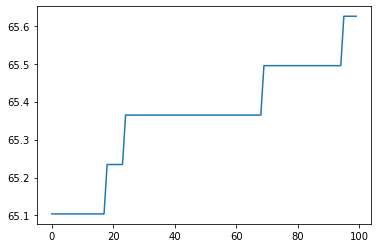

In [4]:
GeneticAlgorithm(cols, last_col, 10, [5,3,2], "relu", 100, 10, True)

In [102]:
class a:
    def __init__(self, v):
        self.list = v
    def write(self):
        print(self.list)

c = [1, 2]
myList = a(c)
myList2 = a(myList.list)
myList.write()
c[0] = 4
myList.write()
myList2.write()
c[1] = 5
myList.write()
myList2.write()

[1, 2]
[4, 2]
[4, 2]
[4, 5]
[4, 5]


In [95]:
a = []
for i in range(2):
    a.append(i)
a

[0, 1]